<h2> Data Preparation </h2>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


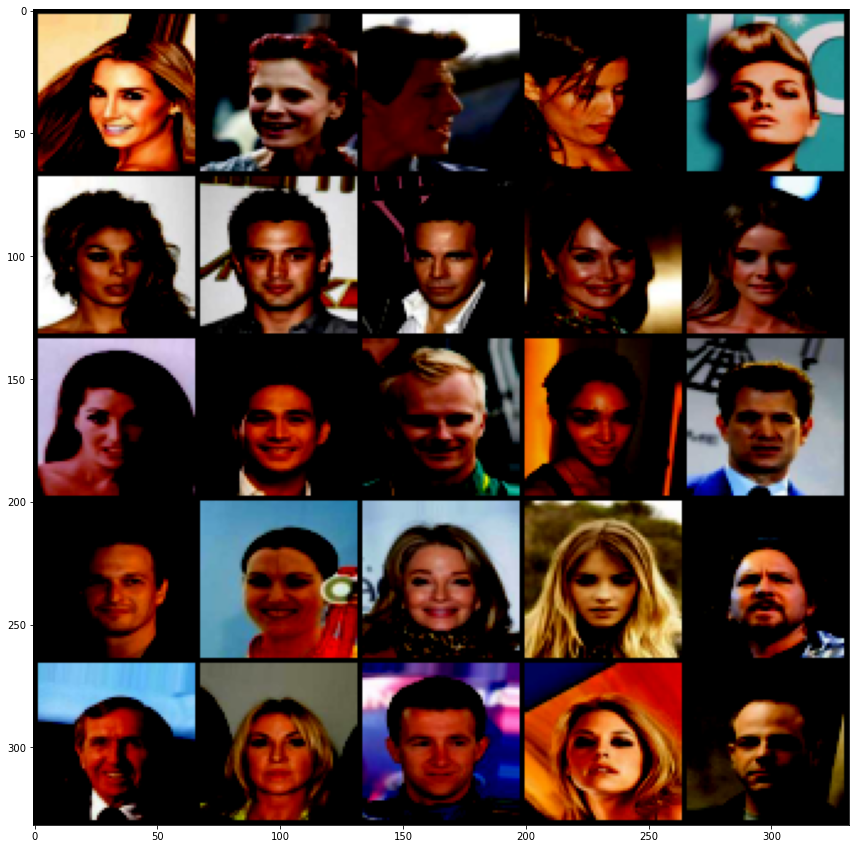

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from utils import weights_init

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.utils as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional
import PIL
import os
import math

batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Normalize([0.5], [0.5])
])

# We can use torchvision package to get MNIST dataset
CELEBA_PATH = r"C:\Users\alvar\Downloads\img_align_celeba"

class CelebA(torch.utils.data.Dataset):
    def __init__(self, root_path:str, transform: Optional[Callable] = None):
        super().__init__()
        self.transform = transform
        self.root_path = root_path
        self.img_paths = os.listdir(root_path)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx:int):
        img = PIL.Image.open(os.path.join(self.root_path, self.img_paths[idx]))
        if self.transform: img = self.transform(img)
        return img

full_dataset = CelebA(CELEBA_PATH, transform=transforms)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,batch_size=64,shuffle=True,drop_last=True)

from torchvision.utils import make_grid
plt.figure(figsize=(15,15))
plt.imshow(make_grid([full_dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

<h2> VAE CLASS </h2>

In [2]:
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()
        self.device = device

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8))

        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)


    def reparametrize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(self.device)
        return multi_norm.mul(std).add_(mean) 
        

    def forward(self, inputs):
        batch_size = inputs.size(0)
        hidden = self.encoder(inputs)
        hidden = hidden.view(batch_size, -1)
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        latent_z = self.reparametrize(mean, logvar)
        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output # reconstructed image

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)


    def reparametrize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(self.device)
        return multi_norm.mul(std).add_(mean)     
    
    def sample(self, size):
        z = torch.randn((size, 100)).to(self.device)
        Z = self.decoder(z)
        return Z
    
    @property
    def device(self): return next(self.parameters()).device

model_vae = VAE().to(device)
optimizer_vae = torch.optim.Adam(model_vae.parameters(), lr=1e-3)

<h2> VAE TRAINING </h2>

In [3]:
def loss_function(recon_x, x, mean, logvar):
    batch_size = recon_x.shape[0]
    eps = 1e-7
    MSEC = nn.MSELoss(reduction='mean')
    MSE = MSEC(recon_x, x) 
    KLD_LOSS = 0.5 * torch.sum(-torch.log(logvar**2 + eps) + logvar**2 + mean**2 - 1, 1)
    KLD = torch.mean(KLD_LOSS)
    return MSE, KLD

def train(pbar):
    model_vae.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    for batch_idx, data in enumerate(dataloader):
        data = data.to(device)
        recon_batch, mu, logvar = model_vae.forward(data)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        optimizer_vae.zero_grad() 
        loss.backward()
        optimizer_vae.step()
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)

epochs=10
with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:
    for epoch in range(1, epochs + 1):
        train(pbar)
        with torch.no_grad():
            sample = model_vae.sample(64).cpu()
            log_img = make_grid(sample)

<ipython-input-3-367a82a026a4>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:


<h2> GAN CLASSES </h2>

In [25]:
class Generator(nn.Module):

    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())

        self.reduce = nn.Sequential(
            nn.Linear(12288, 100, bias=False))
        
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU())
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh())
        
        
    def forward(self, x, vae):
        z = self.reduce(vae)
        x = torch.cat([x, z], 1)
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y


class Discriminator(nn.Module):

    def __init__(self, in_dim, dim=64):
        super().__init__()
        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2))

        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4))


    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [26]:
z_dim = 100
img_dim = 3

D = Discriminator(img_dim).to(device)
G = Generator(z_dim*2).to(device)

[model.apply(weights_init) for model in [D,G]] # Weights initialization

d_optimizer = torch.optim.AdamW(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.AdamW(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()

In [29]:
def train_gan_with_vae(pbar):

    for i, imgs in enumerate(dataloader):
        
        step = epoch * len(dataloader) + i + 1
        
        G.train()
        # leafs
        imgs = imgs.to(device)
        bs = imgs.size(0)
        
        with torch.no_grad():
            recon_batch, _,_ = model_vae.forward(imgs)
        
        z = torch.randn(bs, z_dim).to(device)
        #print(z.size(), recon_batch.flatten(1).size())
        #z2 = torch.cat([z, recon_batch.flatten(1)], 1)
        
        r_lbl = torch.ones(bs).to(device)
        f_lbl = torch.zeros(bs).to(device)

        f_imgs = G(z, recon_batch.flatten(1))

        # train D
        r_logit = D(imgs)
        f_logit = D(f_imgs.detach())
        d_r_loss = bce(r_logit, r_lbl)
        d_f_loss = bce(f_logit, f_lbl)
        d_loss = d_r_loss + d_f_loss

        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # train G
        f_logit = D(f_imgs)
        g_loss = bce(f_logit, r_lbl)
        
        _, mu, logvar = model_vae.forward(f_imgs)
        mse_loss, kld_loss= loss_function(recon_batch, imgs, mu, logvar)
        vae_loss = mse_loss + kld_loss
        
        g_total_loss = g_loss + vae_loss
        
        D.zero_grad()
        G.zero_grad()
        g_total_loss.backward()
        g_optimizer.step()
        
        pbar.set_description(f"[D loss: {d_loss.item()/len(imgs) :.2f}] [G loss: {g_total_loss.item()/len(imgs): .2f}]")
        pbar.update(1)
        
    return f_imgs


n_epochs = 1

with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:
    for epoch in range(n_epochs):
        f_imgs = train_gan_with_vae(pbar)


<ipython-input-29-56f3e450af52>:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=n_epochs*len(dataloader), desc=f"[D loss: ?] [G loss: ?]") as pbar:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


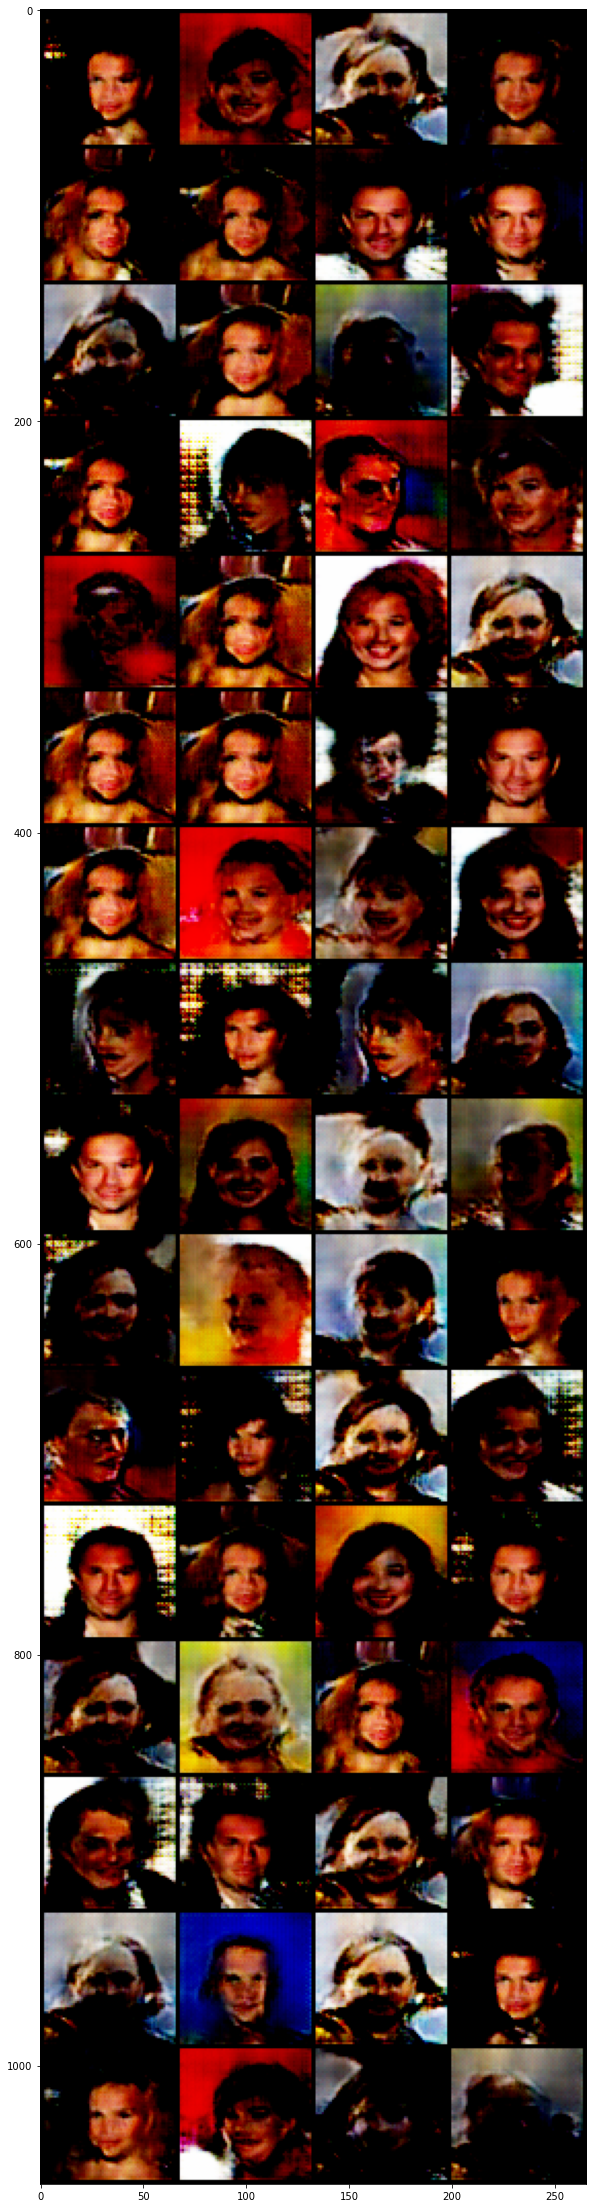

In [30]:
plt.figure(figsize=(17,40))
plt.imshow(make_grid(f_imgs, nrow=4).detach().cpu().permute(1,2,0))